# Install necessary packages

In [ ]:
!pip install elephant
!pip install networkx
!pip install mne
!pip install mne_connectivity

# Import Libraries

In [205]:
import neo
import quantities as pq
from elephant.spike_train_correlation import spike_time_tiling_coefficient

import networkx as nx
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from scipy.stats import pearsonr

# Load Data

In [8]:
well_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Well_data.csv")

In [9]:
well_data.head()

,Unnamed: 0,Time (s),Electrode,Well,Channel
0,80,0.00568,C4_43,C4,43
1,87,0.00608,C4_16,C4,16
2,620,0.07856,C4_16,C4,16
3,626,0.08040,C4_55,C4,55
4,700,0.10656,C4_16,C4,16


This is how my data looks like. This will likely look different from your data. You can either format your data to match this or you can change how the "generate_raster()" function works to handle your data.


# *Handling spike sorted data*
Note: The code below is made for MUA activity (i.e., one signal per channel). For spike-sorted data that may have multiple units from a single channel, my first attempt would be to create "pseudo-channels". This is where you create new channel labels that reflect an arbitrary spatial organization.

For example: If you have 6 channels in a 2x3 grid and each channel has between 0-3 units, you can do the following.

**Original channel labels**: [11, 12, 21, 22, 31, 32]

**Number of units per channel**: [2, 1, 0, 3, 1, 1]

This means channel 11 had 2 units, channel 12 had 1 units, channel 21 had 0 units, etc, etc.

**Pseudo-channel labels**: [1101, 1102, 1201, 2201, 2202, 2203, 3101, 3201]

In this case, I multipled the original channel labels by 100 and added the unit ID. Channels that had no units were ignored.

By doing this, you should still have the option to preserve some spatial organization when visualizing the data. Personally have not looked into this, so external readings may be required to actually get this done. Otherwise, you can skip trying to plot everything in a grid and just do an unstructed network graph.


# Convert data frame into a usable array format

In [34]:
channel_ids = [i for j in range(1, 9) for i in range(j * 10 + 1, j * 10 + 9)]
'''
The above produces the following:
  [11, 12, 13, 14, 15, 16, 17, 18,
  21, 22, 23, 24, 25, 26, 27, 28,
  31, 32, 33, 34, 35, 36, 37, 38,
  41, 42, 43, 44, 45, 46, 47, 48,
  51, 52, 53, 54, 55, 56, 57, 58,
  61, 62, 63, 64, 65, 66, 67, 68,
  71, 72, 73, 74, 75, 76, 77, 78,
  81, 82, 83, 84, 85, 86, 87, 88]
'''

# Sort data frame containing mixed-bag of electrode and spike times based on channel name
def generate_raster(well_data, duration, channel_ids):
  '''
  well_data: Data frame in the format seen above
  duration: Length of recording in seconds (in this case 300 seconds)
  channel_ids: Name of all channels in the format seen in the data frame "channel" column
  '''
  raster = []
  # Loop through each channel regardless of activity
  for channel in channel_ids:
    # If the channel is found in my data (i.e., it had at least 1 spike)
    if int(channel) in well_data["Channel"].to_list():
      # Find spike times associated with that channel
      spiketrain = well_data.loc[well_data["Channel"]==int(channel), well_data.columns.str.contains("Time")].reset_index(drop=True)
      # Convert spike times that occur before the end of the recording (i.e., duration) to an array
      spiketrain = spiketrain.to_numpy().flatten()[spiketrain.to_numpy().flatten() <= duration]
      # Store array
      raster.append(spiketrain)
    # If the channel is not found in my data, I still want to store that it was empty
    else:
      raster.append([])
  return raster

raster = generate_raster(well_data, 300, channel_ids)

# Visualize network activity (as a raster plot)

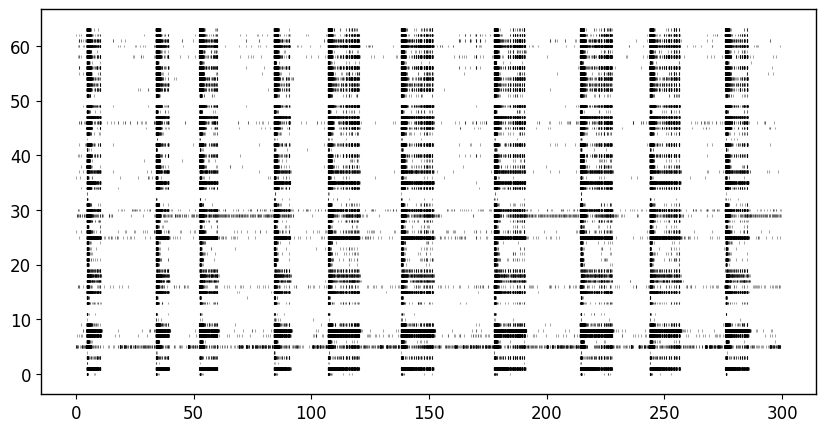

In [40]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);

# Calculate pairwise correlation using Elephant's STTC

In [52]:
def calculate_pairwise_correlations(raster, duration, dt=0.005*pq.s):
  # Create an empty n x n matrix, where n is the number of channels
  sttc_m = np.ones((len(raster), len(raster))) * np.nan

  # Iterate through each channel, compute pairwise correlations, store in matrix in appropriate position
  for i, ch1 in enumerate(raster):
      for j, ch2 in enumerate(raster):
        ch1_spiketrain = neo.SpikeTrain(ch1, units="s", t_stop=duration)
        ch2_spiketrain = neo.SpikeTrain(ch2, units="s", t_stop=duration)
        sttc_m[i][j] = spike_time_tiling_coefficient(ch1_spiketrain, ch2_spiketrain, dt)
  return sttc_m

sttc = calculate_pairwise_correlations(raster, duration=300*pq.s)


# Visualize correlation matrix




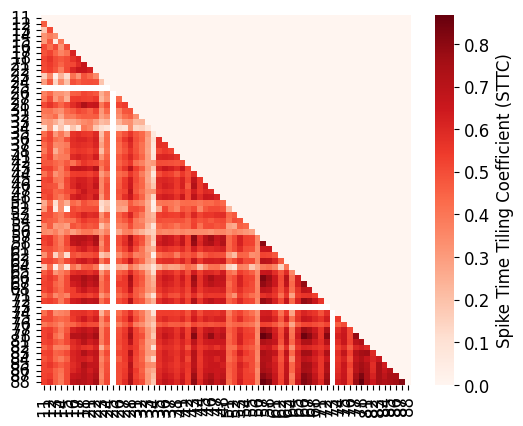

In [70]:
# Since correlation matrix is symmetrical, grab only the lower triangle to avoid repeat correlations
STTC_lt = np.tril(sttc, k=-1)
STTC_lt = np.where(STTC_lt < 0, np.nan, STTC_lt)

# Visualize
hm = sns.heatmap(STTC_lt,
            yticklabels=channel_ids, xticklabels=channel_ids,
            cmap=sns.color_palette("Reds",as_cmap=True), cbar=True,
            cbar_kws={'label': 'Spike Time Tiling Coefficient (STTC)'},
            square=True)
# To do: Fix X-tick label spacing to be every 8th

# Plot distribution of correlations




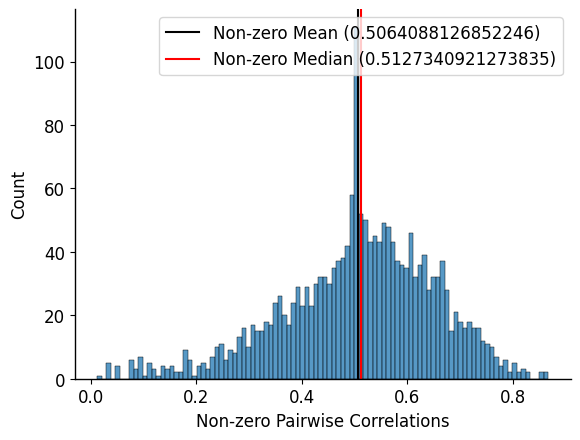

In [135]:
# Filter data so that nan and 0 values are removed.
flattened_nonzero_STTC = [x for x in STTC_lt.flatten() if (x != 0) & (~np.isnan(x))]

# Visualize and descriptive statistics
sns.histplot(data=flattened_nonzero_STTC, bins=100)
plt.xlabel("Non-zero Pairwise Correlations")
plt.axvline(np.nanmean(flattened_nonzero_STTC), color='black')
plt.axvline(np.nanmedian(flattened_nonzero_STTC), color='red')
plt.legend([f"Non-zero Mean ({np.nanmean(flattened_nonzero_STTC)})",f"Non-zero Median ({np.nanmedian(flattened_nonzero_STTC)})"])
sns.despine()

Since mean is slightly less than median, the distribution is left-skewed. But considering how close they are, this distribution is arguably symmetrical.

Text(0, 0.5, 'Spike time tiling coefficient')

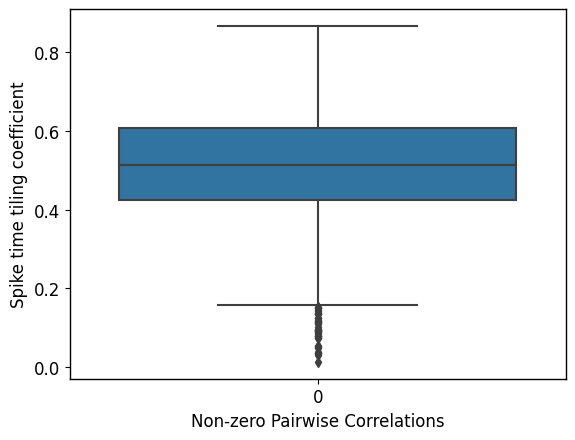

In [136]:
sns.boxplot(data=flattened_nonzero_STTC)
plt.xlabel("Non-zero Pairwise Correlations")
plt.ylabel("Spike time tiling coefficient")

# Determine threshold based on distribution of correlations and filter values

Considering that there can be up to 2048 edges (64 channels x 64 channels / 2), I will be thresholding subsequent visualizations for any correlation greater than the third quartile (~0.6).

In [175]:
THRESHOLD = np.quantile(flattened_nonzero_STTC, 0.75) # Gets 3rd quartile (i.e., end of IQR)
print(f"We will be using a correlation threshold of {THRESHOLD}")

'''
Replace values that didn't meet the threshold to 0. Ideally, you convert them to
nan values, but for some reason,t for some reason the connectivity circle handles
nan values as very large numbers and throws off the n_lines parameter, such that
you need to plot many more lines than needed.
'''
STTC_threshold = np.where(STTC_lt < THRESHOLD, 0, STTC_lt)

We will be using a correlation threshold of 0.6064791131257226


# Visualize connectivity grid

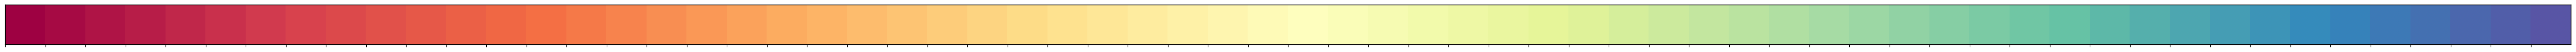

In [176]:
# Create color palette that will be used to visualize spatial position of electrodes
palette = sns.color_palette("Spectral",512)
palette1 = [palette[i] for i in np.arange(1,512,8)]
sns.palplot(palette1)

(-0.7350000000000001,
 7.734999999999999,
 -7.734999999999999,
 0.7350000000000001)

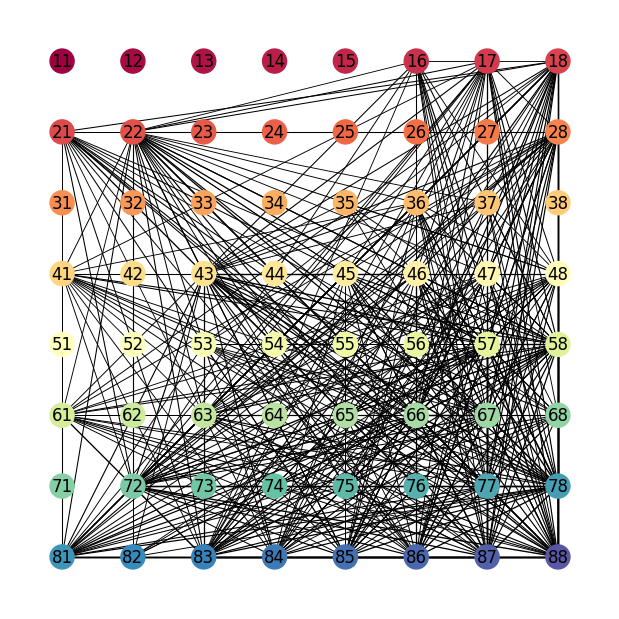

In [183]:
# Create a graph object
plt.figure(figsize=(6,6))
G = nx.Graph()

# Add nodes to the graph
for i in range(64):
  G.add_node(i)

# Add edges to the graph based on the correlations
for i in range(64):
  for j in range(64):
    if i != j:
      correlation = STTC_threshold[i, j]
      if correlation >= THRESHOLD: # Only add node if value passes threshold (probably don't need this anymore)
        G.add_edge(i, j, weight=correlation)
weights = nx.get_edge_attributes(G,'weight').values()
weights = [(w-0.29)*2 for w in list(weights)]

# Create a layout for the graph as a 4x4 grid
pos = {}
for i in range(8):
  for j in range(8):
    pos[i * 8 + j] = (j, -i)

# Create label map with electrode names
mapping = {old_label: new_label for old_label, new_label in zip(G.nodes(), channel_ids)}

# Draw the graph using the grid layout
nx.draw(G, pos, labels=mapping, node_color=palette1,
        with_labels=True, font_color='black', width=weights)

# Display the graph
plt.axis('off')

# Visualize connectivity circle

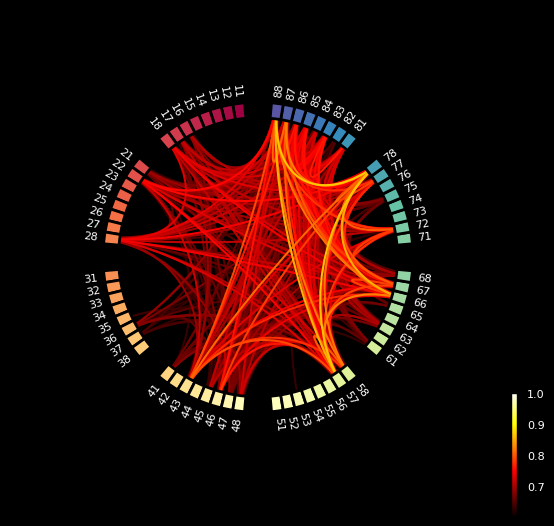

(<Figure size 800x800 with 2 Axes>, <PolarAxes: >)

In [182]:
node_order = list()
node_order.extend(channel_ids)
# This will format the grid. Group boundaries separates distinct rows in this data
node_angles = circular_layout(channel_ids, node_order, start_pos=90, group_boundaries=[0, 8, 16, 24, 32, 40, 48, 56])
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black',
                        subplot_kw=dict(polar=True))
# Plots the top 500 strongest connections
plot_connectivity_circle(STTC_threshold, channel_ids, vmin=THRESHOLD, vmax=1, n_lines=500,
                          node_angles=node_angles, interactive=True,
                          textcolor='white',
                          ax=ax)


# Plot correlation with respect to distance between electrodes

<Axes: >

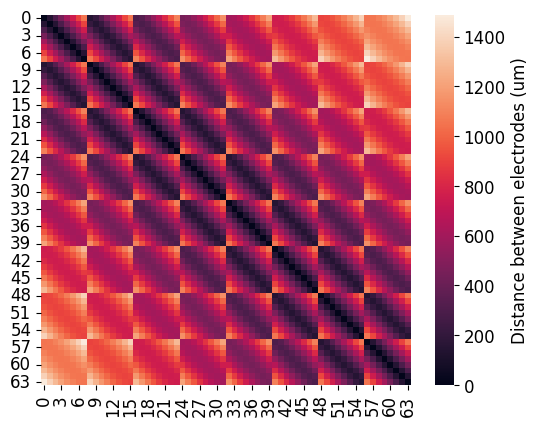

In [189]:
# Calculates a matrix of distances that maps onto the same nxn matrix of correlations
def calculate_distance(electrode_spacing=150, channel_ids=None, electrode_diameter=50):
    '''
    Each well contains 64 electrodes arranged in an 8x8 grid.
    Electrode spacing: 150um
    Electrode diameter: 50um
    Recording area: 1.1mm x 1.1mm
    '''
    distance = []
    for ch1 in channel_ids:
        ch1_x = int(str(ch1)[0])
        ch1_y = int(str(ch1)[1])
        for ch2 in channel_ids:
            ch2_x = int(str(ch2)[0])
            ch2_y = int(str(ch2)[1])
            distance_tmp = np.sqrt((ch2_x-ch1_x)**2 + (ch2_y-ch1_y)**2) * electrode_spacing
            distance.append(distance_tmp)
    distance = np.reshape(distance, (int(np.sqrt(len(distance))),int(np.sqrt(len(distance)))))
    return distance

MEA_distances = calculate_distance(channel_ids=channel_ids)

sns.heatmap(MEA_distances,
            cbar=True, cbar_kws={'label': 'Distance between electrodes (um)'},
            square=True)

In [208]:
# Create a data frame with all the STTCs associated with appropriate distance.
# This data frame makes it easier to plot later, especially once you have other variables that act as groups
distance = MEA_distances.flatten()
flattened_STTC = STTC_lt.flatten() # I am going to use the original STTC (using filtered STTC was only for visualization purposes)
if len(distance) == len(flattened_STTC):
  print(f"Both arrays have matching lengths")
else:
  print(f"Array length mismatch - check how the MEA distances are calculated. Likely incorrect channel_ids")

STTC_distances = pd.DataFrame({"Distance": distance, "STTC": flattened_STTC})
STTC_distances.dropna(inplace=True)
STTC_distances.tail()

Both arrays have matching lengths


,Distance,STTC
4091,600.0,0.722781
4092,450.0,0.738558
4093,300.0,0.759270
4094,150.0,0.810300
4095,0.0,0.000000


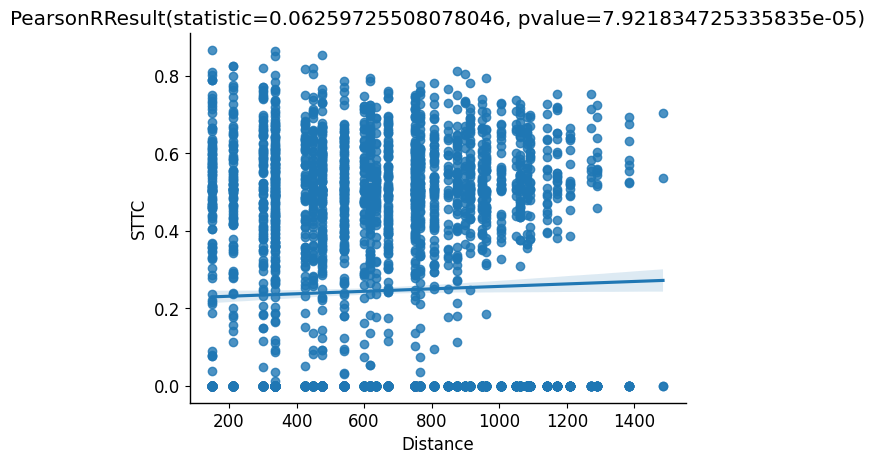

In [209]:
sns.regplot(data=STTC_distances[STTC_distances["Distance"]!=0], x="Distance", y="STTC")
pearsonr = pearsonr(STTC_distances["Distance"], STTC_distances["STTC"])
plt.title(pearsonr)
sns.despine()

regplot performs and then visualizes linear regression model fit.
Based on the calculated Pearson Correlation Coefficient of 0.06, there is a very weak positive correlation between STTC and distance.

This is surprising because it would have been expected that closer electrodes (i.e., shorter inter-channel distance) would be more correlated and that the correlation decreases with increasing distance.